In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [35]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

def inv_poisson(pct):
    MOI = -np.log(1-pct)
    multiple = 1-np.exp(-MOI)*(MOI+1)
    
    return multiple

In [36]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]
temporality.name = 'temporality'

In [37]:
folder = r'..\Skyline_reports'

df = load_herpesvirusPRMreport(os.path.join(folder, 'HCMV_siCPS1.csv'), 'HCMV')
df = df[df.index.get_level_values('temporality')!='unknown']
filename_mapping = df.reset_index()[['treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates


In [78]:
cps1_genomes = pd.read_csv(r'..\data\siCPS1_genomes.csv',index_col=[0, 1, 2])['2^-Delta Ct']
cps1_titers = pd.read_csv(r'..\data\siCPS1_IE1_titers.csv',index_col=[0, 1]).squeeze()
kd_conf = pd.read_csv(r'..\data\siCPS1_KD_confirmation.csv', index_col=[0, 1, 2])['2^-DeltaCt']
tunel = pd.read_csv(r'..\data\siCPS1_TUNEL.csv', index_col=[0, 1])['% apoptotic']
levels = pd.read_csv(r'..\data\CPS1_Sheng2021.csv', index_col=[0, 1]).squeeze().groupby('timepoint').mean()

# Data Normalization

### MS1 normalization

In [41]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(df.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['replicate']).apply(lambda x: x/x.mean())

df_adj = df.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)

### Mean normalization

In [42]:
cols = ['treatment', 'timepoint']
df_norm = mean_normalize(df_adj.unstack(cols)).stack(cols)
df_avg = df_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
df_mean = df_avg.unstack(['replicate']).mean(axis=1)

# Export Supplementary Tables

In [53]:
# export supplementary table
temp = df_norm.unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS5.csv')

# Make Figures

### Fig. 7A

2.5677452806082464


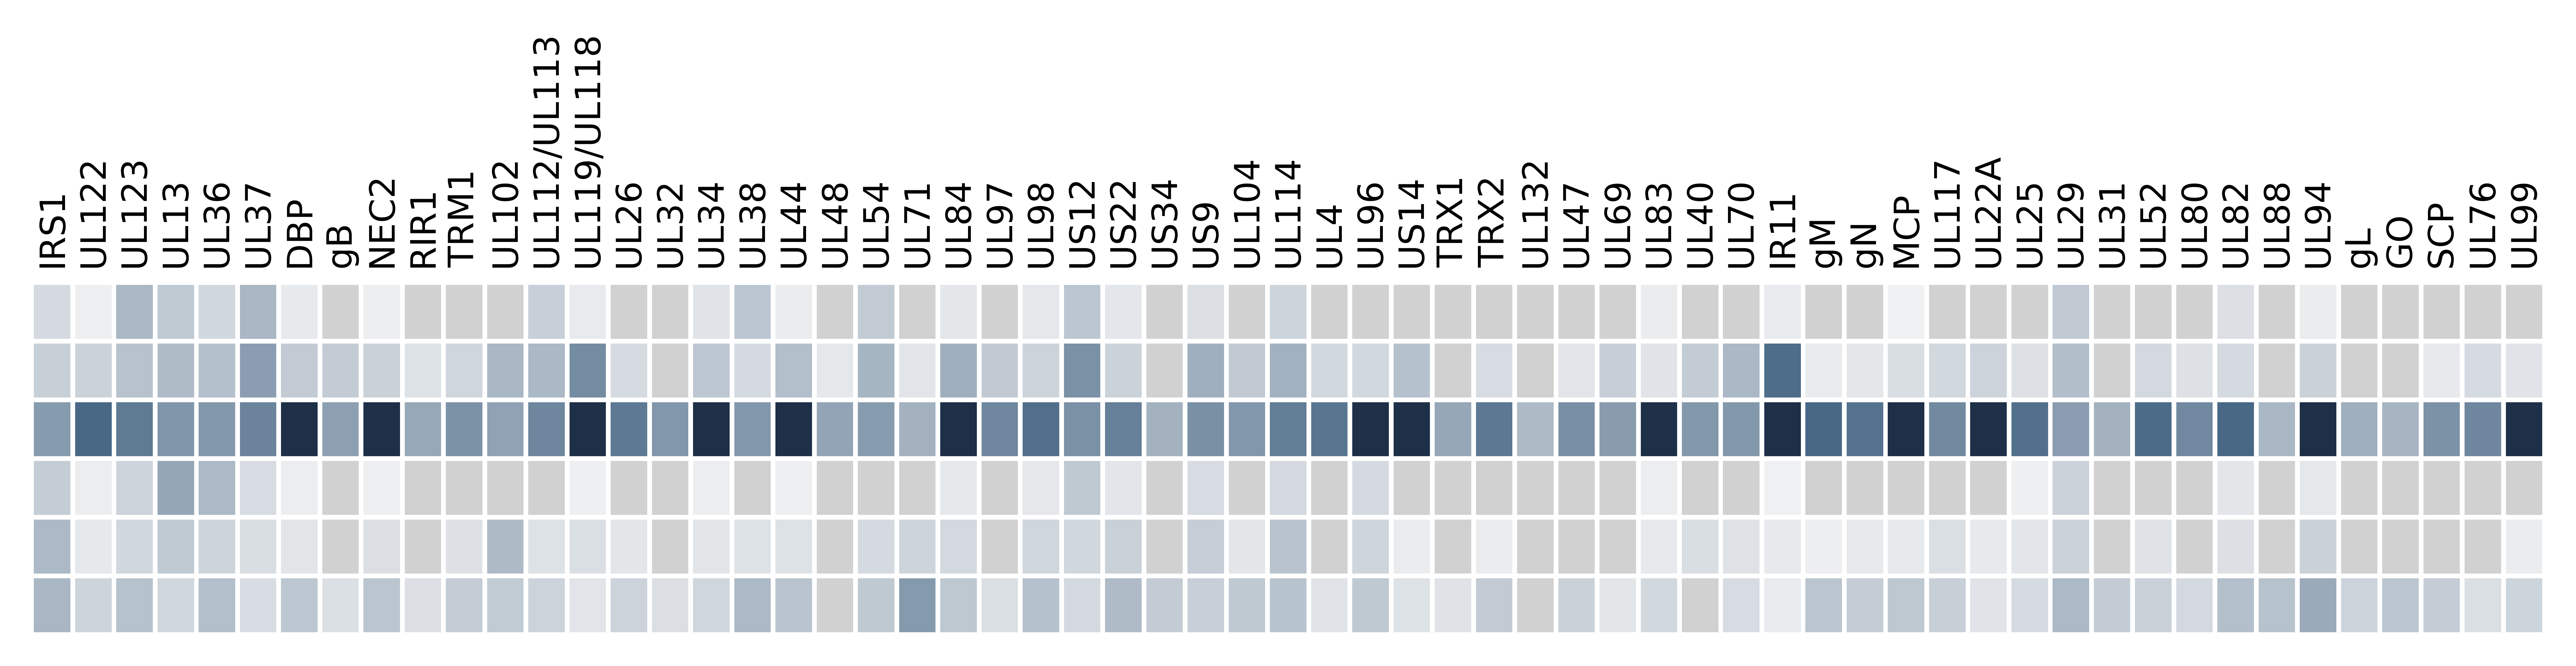

In [95]:
temp = df_mean.unstack('treatment')[['siCTRL', 'siCPS1']].unstack('timepoint')

fig, ax = plt.subplots(figsize = (8.25, 2.2), dpi=1000)

data = pd.concat([temp[temp.index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'LL', 'L']], sort=False)
idx = data.index.names
data=data.reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data = data.set_index(idx)

cm = sns.light_palette((71/256, 103/256, 133/256), reverse=False, as_cmap=True)
cm.set_over((30/256, 48/256, 72/256))
cm.set_under((210/256, 210/256, 210/256))

sns.heatmap(data.T.fillna(-1), 
            cmap=cm, 
            ax=ax, 
            vmax=data.melt()['value'].describe(percentiles=[.95])['95%'], 
            vmin=0,
            linewidth=1,
            xticklabels = data.index.get_level_values('Protein Gene'),
            cbar=False
           )

print(data.melt()['value'].describe(percentiles=[.95])['95%'],)
ax.xaxis.tick_top()
ax.tick_params(size=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=90)

ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig7A.svg', bbox_inches='tight')
plt.show()

### Fig. 7B

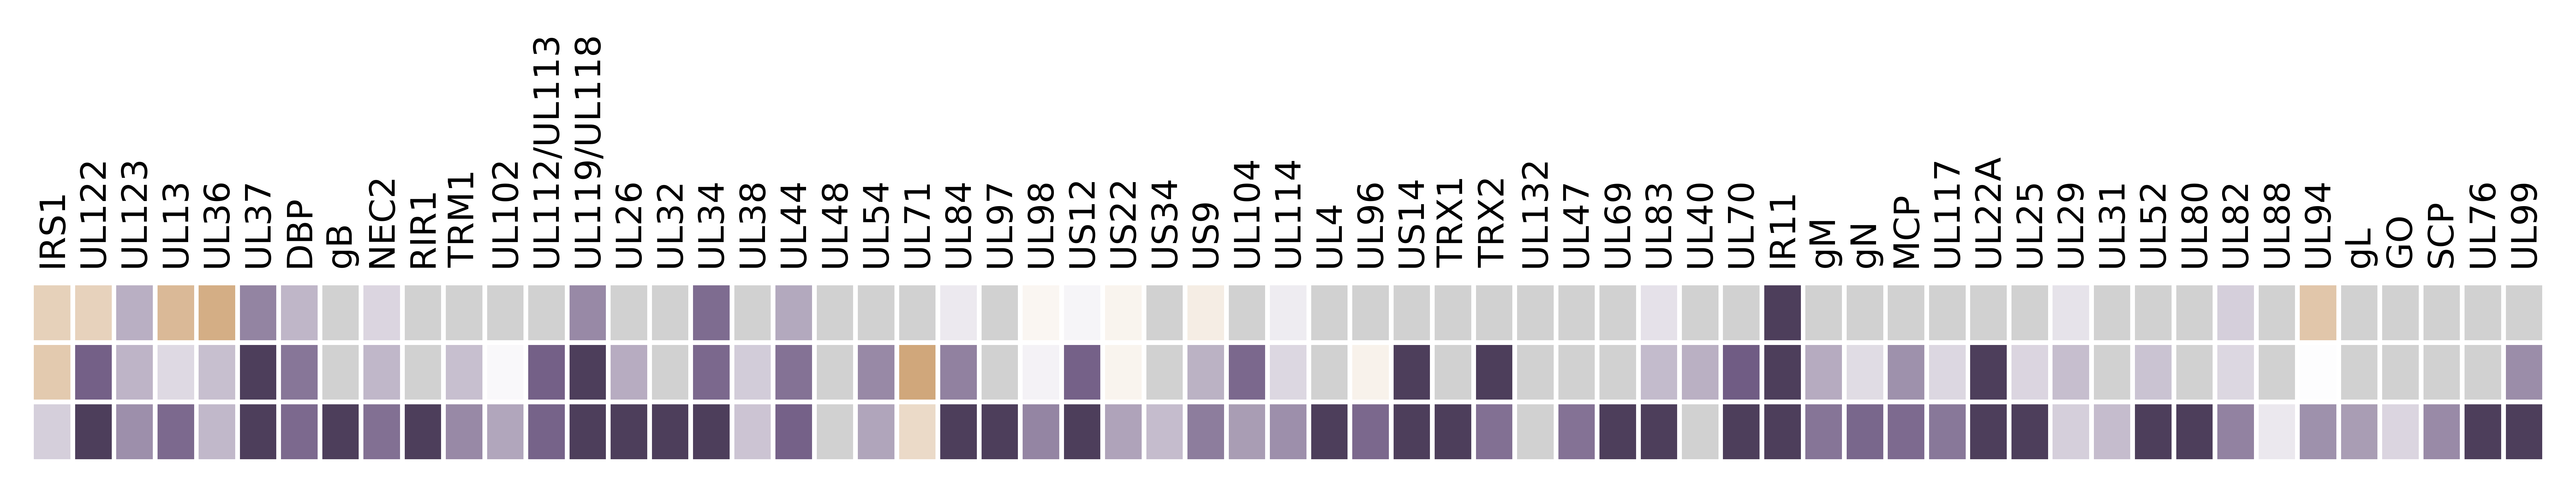

In [100]:
temp = df_mean.unstack('treatment')[['siCTRL', 'siCPS1']].unstack('timepoint')
temp_log = np.log2(temp['siCPS1']/temp['siCTRL'])

fig, ax = plt.subplots(figsize = (8.25, 1.65), dpi=1000)

data = pd.concat([temp_log[temp_log.index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'LL', 'L']], sort=False)
idx = data.index.names
data=data.reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data = data.set_index(idx)

div_cmap = sns.blend_palette([tuple(np.array([108, 87, 128])/256), '#FFFFFF', tuple(np.array([176, 106, 32])/256)], as_cmap=True)
div_cmap.set_under(tuple(np.array([77, 62, 91])/256))
div_cmap.set_over(tuple(np.array([129, 78, 24])/256))
ax.set_facecolor((210/256, 210/256, 210/256))

sns.heatmap(data.T, 
            cmap=div_cmap, 
            ax=ax, 
            vmax=2, 
            vmin=-2,
            linewidth=1,
            center = 0,
            xticklabels = data.index.get_level_values('Protein Gene'),
            cbar=False
           )

ax.xaxis.tick_top()
ax.tick_params(size=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=90)

ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig7B.svg', bbox_inches='tight')
plt.show()

### Fig. 7C

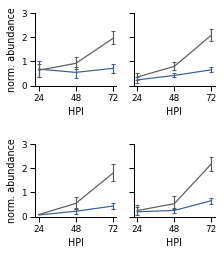

In [115]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (3.2, 3.6), sharey=True)

for ax, t in zip(axs.flatten(), ['IE', 'DE', 'LL', 'L']):
    data = df_mean[(df_mean.index.get_level_values('temporality')==t)]
    sns.lineplot(data=data.reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 hue_order = ['siCPS1', 'siCTRL'],
                 palette = [bright_pal[1], pal[-1]], ax=ax,
                 err_style='bars', err_kws = {'capsize': 2}
                )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0, 1, 2, 3])
    ax.set_ylim(ax.get_ylim()[0], 3)
    ax.set_xticks([24, 48, 72])
    ax.set_ylabel('')
    ax.set_xlabel('HPI')

#     annots = add_stars(data.unstack('treatment').groupby('timepoint').apply(TTEST).squeeze().fillna(1))
#     y = data.unstack('treatment')['siCTRL'].groupby('timepoint').apply(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x))[1])

#     for (x, y_), s in zip(y.iteritems(), annots):
#         ax.text(x, y_+0.1, s, ha='center', fontsize=6.5)
            
[ax.set_ylabel('norm. abundance') for ax in axs[:, 0]]
fig.tight_layout()

plt.subplots_adjust(hspace=0.8)
fig.savefig(r'..\figures\Fig7C.png', dpi=1000, bbox_inches='tight')

plt.show()

### Fig. 7D

326.20619604124903


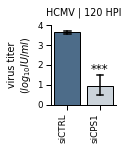

In [120]:
fig, ax = plt.subplots(figsize = (1.8, 2.2))

print(1/(cps1_titers.groupby('sample').mean()['siCPS1']/cps1_titers.groupby('sample').mean()['siCTRL']))

data=np.log10(cps1_titers)
sns.barplot(data=data.reset_index(), 
            x='sample', y='titer (IU/ml)', 
            ax=ax,
            palette=hcmv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k', errcolor='k'
            )

ax.set_title('HCMV | 120 HPI', y=1.05)
ax.set_ylabel('virus titer\n($log_{10}IU/ml$)')

ax.set_xlabel('')
ax.set_yticks(range(5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['siCTRL', 'siCPS1'], rotation = 90, ha='right')

ax.text(1, data.unstack('sample')['siCPS1'].mean()+0.65, add_stars(TTEST(data.unstack('sample'))).values[0], ha='center', fontsize=12)

fig.tight_layout()
fig.savefig(r'..\figures\Fig7D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 7E

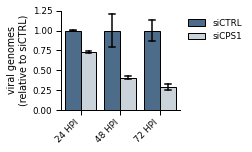

In [138]:
fig, ax = plt.subplots(figsize=(3.6, 2.2))
sns.barplot(
    data=(cps1_genomes.unstack('timepoint')/cps1_genomes.groupby(['sample', 'timepoint']).mean().loc['siCTRL']).stack().reset_index(), 
    x='timepoint', y=0, 
    hue='sample', 
    hue_order = ['siCTRL', 'siCPS1'], 
    palette = hcmv_palette([10, 200]),
    capsize=0.15, 
    errwidth=1.5, 
    saturation=1,
    linewidth=1, 
    edgecolor='k', 
    errcolor='k',
    ax=ax
)

ax.set_ylim(0, 1.25)

handles, labels = ax.get_legend_handles_labels()
if len(labels)>2:
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      bbox_to_anchor = (1, 1, 0, 0),
#       loc='lower left',
#       handletextpad=0.5, 
#       handlelength=1.5,
     )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('viral genomes\n(relative to siCTRL)')
ax.set_xlabel('')


ax.set_xticklabels([i._text+' HPI' for i in ax.get_xticklabels()], rotation=45, ha='right')

fig.tight_layout()

fig.savefig(r'..\figures\Fig7E.png', dpi=1000, bbox_inches='tight')

### Fig. S6G

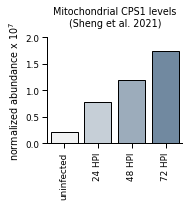

In [89]:
fig, ax = plt.subplots(figsize=(2.8, 3))
sns.barplot(data=(levels/10**7).reset_index(), 
            x='timepoint', 
            y='abundance', 
            ax=ax, 
            palette = hcmv_palette(np.linspace(0, 1, 5).tolist()[::-1]),
            linewidth=1,
            edgecolor='k',
            saturation=1
           )

ax.set_ylabel('normalized abundance x $10^7$')
ax.set_title('Mitochondrial CPS1 levels\n(Sheng et al. 2021)', y=1.05)
ax.set_ylim(0, 2)

ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['uninfected', '24 HPI', '48 HPI', '72 HPI'], rotation=90)

fig.tight_layout()
fig.savefig(r'..\figures\FigS6G.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6H

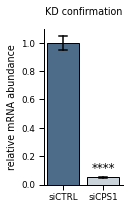

In [68]:
fig, ax = plt.subplots(figsize=(1.9, 3))
sns.barplot(data=(kd_conf/kd_conf.unstack('sample').mean()['CTRL']).reset_index(), x='sample', 
            order = ['CTRL', 'CPS1'], y='2^-DeltaCt', ax=ax, palette=hcmv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k', errcolor='k')
ax.set_ylabel('relative mRNA abundance')
ax.set_title('KD confirmation', y=1.05)

ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['siCTRL', 'siCPS1'])

ax.text(1, (kd_conf/kd_conf.unstack('sample').mean()['CTRL']).loc['CPS1'].mean()+.04, add_stars(TTEST((kd_conf/kd_conf.unstack('sample').mean()['CTRL']).unstack('sample'))).values[0], ha='center', fontsize=12)

fig.tight_layout()
fig.savefig(r'..\figures\FigS6H.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6I

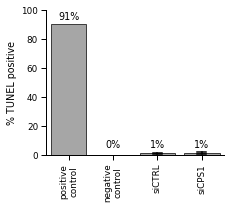

In [77]:
fig, ax = plt.subplots(figsize = (3.3, 3))
x_order = ['positive control', 'negative control', 'siCTRL', 'siCPS1']

sns.barplot(data=tunel.reset_index(), 
            x='sample', y='% apoptotic', 
            ax=ax,
            palette=['grey']*4, 
            capsize=0.2, errwidth=1.5, saturation=0.6, alpha = 0.7,
            linewidth=1, edgecolor='k', errcolor='k',
            order = ['positive control', 'negative control', 'siCTRL', 'siCPS1'],
            hue_order = ['positive control', 'negative control', 'siCTRL', 'siCPS1']
            )

ax.set_xticklabels(['positive\ncontrol', 'negative\ncontrol', 'siCTRL', 'siCPS1'], rotation=90)

ax.set_ylabel('')
ax.set_xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0, 100)
ax.set_ylabel('% TUNEL positive')

ax.text(0, tunel.groupby('sample').mean().max()+3, '{:.0f}%'.format(tunel.groupby('sample').mean().max()), ha='center')

for i, x in enumerate(x_order[1:], 1):
    ax.text(i, 5, '{:.0f}%'.format(tunel.groupby('sample').mean()[x]), ha='center')

fig.tight_layout()
fig.savefig(r'..\figures\FigS6I.png', dpi=1000, bbox_inches='tight')
plt.show()